## Titanic datasett
### Grunnleggende maskinlæringsoppgave
Vår tilnærming: Vise effekten av å kunne ta med mange parametre. (Positiv effekt, forhåpentligvis)

In [2]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, ParameterGrid
from sklearn import tree, naive_bayes
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%config InlineBackend.figure_format = 'svg'

In [3]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X = X.drop(['boat', 'body', 'home.dest'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [4]:
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C


In [5]:
# Hvor mange tomme felter er det i hver kolonne?
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         220
sibsp         0
parch         0
ticket        0
fare          1
cabin       813
embarked      1
dtype: int64

In [6]:
# Vi må gjøre no med nullene i age, cabin og embarked.
# Vi sletter cabin - kolonna.
X_train = X_train.drop(['cabin'], axis=1)
X_test = X_test.drop(['cabin'], axis=1)

In [7]:
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         220
sibsp         0
parch         0
ticket        0
fare          1
embarked      1
dtype: int64

In [8]:
# FØr vi gjør noe med manglende alder, finner vi tittelen på folk.
# Den er det noen som bruker til segmentering
# name har navnet på denne formen: Silvey, Mr. William Baird
# Tittelen er det som kommer foran eneste/ første punktum, og etter et mellomrom.

X_train['title'] = X_train['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['title'] = X_test['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [9]:
X_train

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,title
547,2.0,"Richard, Mr. Emile",male,23.0,0.0,0.0,SC/PARIS 2133,15.0458,C,Mr
238,1.0,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0.0,1.0,24160,211.3375,S,Mrs
961,3.0,"Lennon, Miss. Mary",female,NaN,1.0,0.0,370371,15.5000,Q,Miss
191,1.0,"Loring, Mr. Joseph Holland",male,30.0,0.0,0.0,113801,45.5000,S,Mr
168,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0000,NaN,Miss
...,...,...,...,...,...,...,...,...,...,...
867,3.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1.0,1.0,3101298,12.2875,S,Mrs
553,2.0,"Rugg, Miss. Emily",female,21.0,0.0,0.0,C.A. 31026,10.5000,S,Miss
1045,3.0,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,18.0,0.0,0.0,347078,7.7500,S,Mr
616,3.0,"Ali, Mr. Ahmed",male,24.0,0.0,0.0,SOTON/O.Q. 3101311,7.0500,S,Mr


In [10]:
# Nå kan vi bruke tittelen og si at de som mangler angivelse av alder, de kan få median av alder for den gruppen.
X_train["age"] = X_train["age"].fillna(X_train.groupby("title")["age"].transform("median"))
X_test["age"] = X_test["age"].fillna(X_test.groupby("title")["age"].transform("median"))
# Vi gjør det samme med fare og embarked
X_train["fare"] = X_train["fare"].fillna(X_train.groupby("title")["fare"].transform("median"))
X_test["fare"] = X_test["fare"].fillna(X_test.groupby("title")["fare"].transform("median"))

In [11]:
X_train.isnull().sum()

pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    1
title       0
dtype: int64

In [12]:
# embarked inneholder bokstaver, så der kan vi ikke brukge median. Vi tar det vanligste ombordstigningsstedet for de to som mangler:
X_train["embarked"].value_counts()

S    739
C    213
Q     94
Name: embarked, dtype: int64

In [13]:

X_train["embarked"] = X_train["embarked"].fillna("S")
X_test["embarked"] = X_test["embarked"].fillna("S")
X_test["embarked"].value_counts()

S    176
C     57
Q     29
Name: embarked, dtype: int64

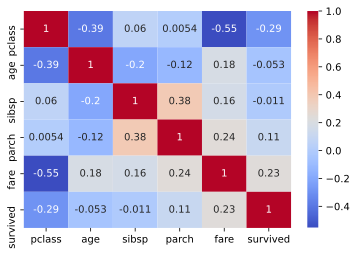

In [14]:
# Korrelasjoner
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "coolwarm")

### Korrelasjoner
I tabellen over, ser vi at Passasjerklasse (første andre, tredje) korrelerer med overlevelse. Negativt tall fordi høyt tall på passasjerklasse gir lavere sannsynliget for overlevelse.
Det samme kommer fram ved at høyere billettpris gir høyere sannsynlighet for overlevelse.
sibsp forteller  hvor mange søsken eller ektefelle som er med på turen
parch gir hvor mange foreldre eller barn som er med på turen.
kjønn er ikke med, siden den verien fortsatt er bokstav-verdi, og derfor får vi ikke til å lage korrelasjonskoeffisient.
Men vi kan se på noen visualiseringer:


1.0    156
3.0    150
2.0     94
Name: pclass, dtype: int64


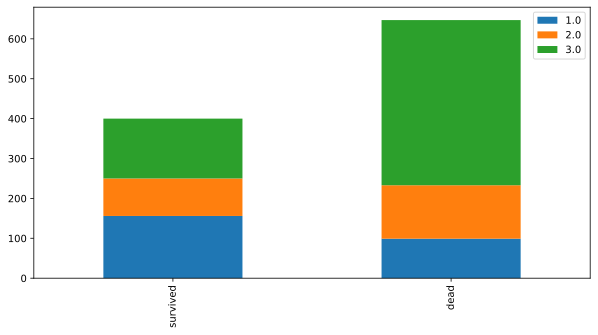

In [15]:
# https://www.kaggle.com/minsukheo/titanic-solution-with-sklearn-classifiers
def bar_chart(feature):
    survived = X_comb[X_comb['survived']==1][feature].value_counts()
    dead = X_comb[X_comb['survived']==0][feature].value_counts()
    print(survived)
    df = pd.DataFrame([survived,dead])
    df.index = ['survived','dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
bar_chart ("pclass")
## Vi ser at flertallet av de i første klasse overlevde, mens flertallet av de på tredje klasse døde.

female    269
male      131
Name: sex, dtype: int64


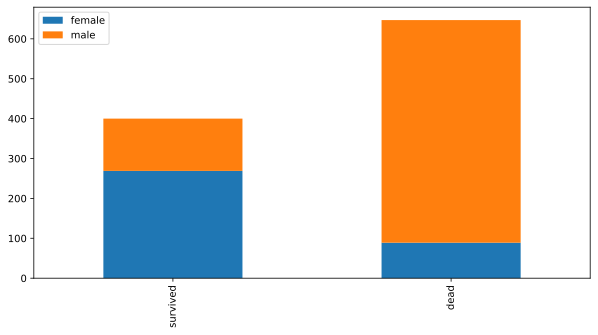

In [16]:
# For kjønn får vi dette:
bar_chart ("sex")
#Her ser vi en sterk ubalanse: Flertallet av menna døde, flertallet av kvinnene overlevde

<a id='hl1'></a>
Vi kan for øvingensskyld stoppe der, og se hva vi får ut av å bruke denne informasjonen.
## Vi grupperer folk i både klasse og kjønn, og se andelen som overlevde

In [17]:

print("klasse", "kjønn","\t","overl", "\t","ant", "\t", "andel overlevende")
df_kjonn_klasse = pd.DataFrame()
for pc, pcg in X_comb.groupby("pclass"):
    for sx, sxg in pcg.groupby("sex"):
        survived = len(sxg[sxg['survived']==1])
        print(int(pc), sx,"\t",survived, "\t",len(sxg), "\t", round(survived/ len(sxg), 3) )
        df_kjonn_klasse = df_kjonn_klasse.append({"klasse": int(pc), "kjønn": sx, "antall":len(sxg) , "orerlevende":survived, "andel_overlevende": round(survived/ len(sxg), 3) }, ignore_index=True)

df_kjonn_klasse.to_csv("df_kjonn_klasse")

klasse kjønn 	 overl 	 ant 	 andel overlevende
1 female 	 107 	 109 	 0.982
1 male 	 49 	 146 	 0.336
2 female 	 77 	 85 	 0.906
2 male 	 17 	 143 	 0.119
3 female 	 85 	 164 	 0.518
3 male 	 65 	 400 	 0.163


Vi ser at for alle kvinner er sannsynligheten for å overleve (så vidt for 3. klasse) over 50%. 
For alle menn er sansynligheten for å overleve under 50%. 
Vi kan derfor si at vi predikerer for alle menn at de vil dø, mens for alle kvinner predikerer vi at de vil overleve.


In [18]:
# Prediksjon på bakgrunn av kjønn:
pd_est = X_comb[["sex", "survived"]].copy()
pd_est["estimated"] = 0
pd_est.loc[pd_est["sex"]=="female","estimated"] = 1
pd_est["correct"] = 0
pd_est.loc[pd_est["survived"] ==pd_est["estimated"], "correct"] = 1

for sx, sxg in pd_est.groupby("sex"):
    print(sx, "andel korrekt estimerte\t", round(sxg["correct"].sum() / len(sxg), 3) )
print("samlet", "andel korrekt estimerte\t", round(pd_est["correct"].sum() / len(pd_est),3) )

female andel korrekt estimerte	 0.751
male andel korrekt estimerte	 0.81
samlet andel korrekt estimerte	 0.79


In [19]:
# Så bare ved å estimere hvem som overlevde, ut fra kjønn, får vi 77,5% riktig.
# Modellene vi lager, må slå det for å ha noen verdi. 
# Nå skal vi bruke mer avanserte verktøy som kan ta inn mange parametre (mye informasjon på hver person).
# Når vi trener statistiske modeller må vi ha tallverdier i alle kolonner
sex_conv = {"male":0, "female":1}

modeller = [naive_bayes.CategoricalNB(), tree.DecisionTreeClassifier()]
df_x = X_train[["sex", "pclass"]].copy()
df_x["sex"] = df_x["sex"].map(sex_conv)

dtc = tree.DecisionTreeClassifier()
nbc = naive_bayes.MultinomialNB()


print("Decision tree", round(cross_val_score(dtc, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))
print("Naive Bayes", round(cross_val_score(nbc, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))
# dtc.fit(df_x, y_train)
# tree.plot_tree(dtc)

Decision tree 0.783
Naive Bayes 0.79


In [20]:
#Vi ser at Decision tree og Naive Bayes er like gode som å bare estimere utfra kjønn
# Men nå bygger vi opp dataene med flere kolonner
#  'age', 'sibsp', 'parch', 'fare'
# Men da må vi 'normalisere' dataene så alle ligger mellom 0 og 1, ellers vil de 
# dataene med høye verdier, som alder og pris, overskygge de andre.
df_x = X_train[["sex", "pclass","age" ]].copy()
df_x["sex"] = df_x["sex"].map(sex_conv)

modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))






# print("Naive Bayes", round(cross_val_score(nbc, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))


Decision tree 0.784
Naive Bayes 0.79


In [21]:
# Ikke mye å hente på å legge til alder.
# Vi tar med resten også. 
df_x = X_train[["sex", "pclass","age" , 'fare']].copy()
df_x['family_size'] = X_train['parch'] + X_train['sibsp'] # Slå sammen vertikale og horisontale fam medl
df_x["sex"] = df_x["sex"].map(sex_conv)
df_x['is_alone'] = 1
df_x['is_alone'].loc[df_x['family_size'] > 1] = 0

df_x_test = X_test[["sex", "pclass","age" , 'fare']].copy()
df_x_test['family_size'] = X_test['parch'] + X_test['sibsp'] # Slå sammen vertikale og horisontale fam medl
df_x_test["sex"] = df_x_test["sex"].map(sex_conv)
df_x_test['is_alone'] = 1
df_x_test['is_alone'].loc[df_x_test['family_size'] > 1] = 0


modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))



Decision tree 0.77
Naive Bayes 0.683


In [22]:
# Ikke noe bedre. Klart dårligere for Naive Bayes. Vi henter inn litt tyngre skyts: random forest og SVM
modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB(), 
            "Support Vector Machine":SVC (),"Random forest": RandomForestClassifier()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))


Decision tree 0.774
Naive Bayes 0.683
Support Vector Machine 0.67
Random forest 0.805


Nå har vi en liten gevinst.  
Random Forest gir oss 79,8 % riktig estimat av om folk døde, basert på klasse, kjønn, bilettpris, alder, og antall familiemedlemmer som var med.
Da vi bare esteimerte basert på kjønn, fikk vi 77,5% riktig.  

For å komme videre, skal vi bruke ombordstigingshavn og tittel. Vi bruker "One-hot" encoding der vi lager ei kolonne for hver kategori, og så setter vi 1 på de som denne kategorien gjelder for.
 

In [23]:
ports = list(X_train["embarked"].unique())
ports

['C', 'S', 'Q']

In [24]:
for port in X_train["embarked"].unique():
    df_x[port] = 0
    df_x.loc[X_train["embarked"]==port, port] = 1
    df_x_test[port] = 0
    df_x_test.loc[X_test["embarked"]==port, port] = 1


In [25]:
print(X_train["title"].value_counts()[:7])
print(X_train["title"].unique())
titles = ['Mrs', 'Mr', 'Miss' ,'Master']
for title in titles:
    df_x[title] = 0
    df_x.loc[X_train["title"]==title, title] = 1
    df_x_test[title] = 0
    df_x_test.loc[X_test["title"]==title, title] = 1

Mr        623
Miss      197
Mrs       155
Master     48
Rev         6
Dr          5
Col         3
Name: title, dtype: int64
['Mr' 'Mrs' 'Miss' 'Master' 'Col' 'Major' 'Rev' 'Don' 'Ms' 'Capt' 'Mlle'
 'Dr' 'Jonkheer' 'Sir' 'Lady']


In [26]:
modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB(), 
            "Support Vector Machine":SVC(),"Random forest": RandomForestClassifier()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))

Decision tree 0.77
Naive Bayes 0.693
Support Vector Machine 0.67
Random forest 0.8


### Vi er fortsatt ikke over 80%
Nå skal vi utforske hyperparametrene på SVM of Random Forest. 

Random Forest er densom har gjort det best så langt, og SVM har erfaringsvis mye å hente på hyperparameter tuning.



In [27]:
# Lager manuell train - dev splitt, fordi det blir litt mye å kjøre crossvalidation
dev_X_train, dev_X_test, dev_y_train, dev_y_test = train_test_split(df_x, y_train, test_size=0.2)
collect = pd.DataFrame()

params = {'max_depth': [6,9, None], 
         'n_estimators':[ 150, 200, 250, 300], 
          'max_features': ['auto', 'sqrt', 'log2'],
          'criterion' : ['gini', 'entropy']
            }

modell = RandomForestClassifier()

def kjor_random_forest(collect):
    for g in ParameterGrid(params):
        keep = g
        modell.set_params(**g)
        steps = [('scaler', StandardScaler()), ('model', modell) ]
        pipeline = Pipeline(steps)
        pipeline.fit( dev_X_train, dev_y_train) 
        acc = round(accuracy_score( dev_y_test, pipeline.predict(dev_X_test)) , 4)
        keep["model"] = "Random Forest"
        keep["accuracy"] = acc
        collect = collect.append(pd.Series(keep), ignore_index=True)
        print(g , acc)
    return collect
''' {'model__n_estimators': 200,
 'model__max_features': 3,
 'model__max_depth': 6,
 'model__criterion': 'gini',
 'model__bootstrap': True}   '''
# collect = kjor_random_forest(collect) # Tar lang tid
# collect.to_csv( "logg_"+datetime.now().strftime("%H%M%S"))

" {'model__n_estimators': 200,\n 'model__max_features': 3,\n 'model__max_depth': 6,\n 'model__criterion': 'gini',\n 'model__bootstrap': True}   "

In [28]:
# df_x.isnull().values.any()
print(df_x.columns)
df_x.isnull().sum()
len(df_x), len(y_train)

Index(['sex', 'pclass', 'age', 'fare', 'family_size', 'is_alone', 'C', 'S',
       'Q', 'Mrs', 'Mr', 'Miss', 'Master'],
      dtype='object')


(1047, 1047)

In [29]:
# Det samme for SVC

# Nå har vi så krevende modeller at det blir mye styr å kjøre crossvalidation

params = {'C': [0.2, 1, 5]
    , 'kernel': ['linear','rbf']
    , 'class_weight':['balanced', None]}

modell = SVC()
def kjor_svc(collect):
    for g in ParameterGrid(params):
        keep = g
        modell.set_params(**g)
        steps = [('scaler', StandardScaler()), ('model', modell) ]
        pipeline = Pipeline(steps)
        pipeline.fit( dev_X_train, dev_y_train) 
        acc = round(accuracy_score( dev_y_test, pipeline.predict(dev_X_test)) , 4)
        print(g , acc)
        keep["model"] = "SVC"
        keep["accuracy"] = acc
        collect = collect.append(pd.Series(keep), ignore_index=True)
    return collect
# collect = kjor_svc(collect)
# collect.to_csv( "logg_"+datetime.now().strftime("%H%M%S"))

## Med testsettet

{'C': 0.2, 'class_weight': 'balanced', 'kernel': 'linear'} 0.8015
{'C': 0.2, 'class_weight': 'balanced', 'kernel': 'rbf'} 0.8053
{'C': 0.2, 'class_weight': None, 'kernel': 'linear'} 0.813
{'C': 0.2, 'class_weight': None, 'kernel': 'rbf'} 0.8168
{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'} 0.8053
{'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'} 0.8168
{'C': 1, 'class_weight': None, 'kernel': 'linear'} 0.813
{'C': 1, 'class_weight': None, 'kernel': 'rbf'} 0.8206
{'C': 5, 'class_weight': 'balanced', 'kernel': 'linear'} 0.8053
{'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'} 0.8206
{'C': 5, 'class_weight': None, 'kernel': 'linear'} 0.813
{'C': 5, 'class_weight': None, 'kernel': 'rbf'} 0.813

## Men hva med  litt mer skikkelig kunstig intelligens? 
Jeg er litt usikker på når vi skal bruke begrepet "Kunstig intelligense", men jeg vet hvordan bruke nevrale nettverk, og dype nevrale nettverk.
Vi kjører tester også med å trene opp en modell baserrt på dype nevrale nett:


In [30]:


params = {'hidden_layer_sizes':[(200), (400), (30,150,30)]
        , 'solver': [ 'sgd', 'adam']
        , 'learning_rate_init': [0.005, 0.001, 0.0001]}

modell = MLPClassifier()
def kjor_nn(collect):
    for g in ParameterGrid(params):
        keep = g
        modell.set_params(**g)
        steps = [('scaler', StandardScaler()), ('model', modell) ]
        pipeline = Pipeline(steps)
        pipeline.fit( dev_X_train, dev_y_train) 
        acc = round(accuracy_score( dev_y_test, pipeline.predict(dev_X_test)) , 4)
        print(g , acc)
        keep["model"] = "Neural network"
        keep["accuracy"] = acc
        collect = collect.append(pd.Series(keep), ignore_index=True)
    return collect
# collect = kjor_nn(collect)
# collect.to_csv( "logg_"+datetime.now().strftime("%H%M%S"))

### Resultat fra eksperimentene er lagret i logg-filene 
Når vi kjører alt dette, får vi at vår beste modell er:
```
accuracy    criterion	max_depth	max_features	model	        n_estimators
0,8667	    gini	    6.0	        log2	        Random Forest	150.0 
```

Vi skal nå hente fram testdataene, som vi ikke har brukt ennå.
Og så sammenligner vi med den første damer overlever / menn dør - modell
Vi trener beste modell på nytt, nå med alle treningsdata, siden iv skal teste på testdataene.

In [31]:
    modell = RandomForestClassifier(criterion = 'gini', max_depth=6, max_features='log2', n_estimators = 150)
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    pipeline.fit( df_x, y_train) 
    acc = round(accuracy_score( y_test, pipeline.predict(df_x_test)) , 4)
    print("Vår beste modell, evaluert på testsettet:", acc)

Vår beste modell, evaluert på testsettet: 0.7977


In [43]:
def sex_estimator(df):
    """ Estimerer overlevende på bakgrunn av kjønn. 
    Kolonnen sex er allerede 1 for kvinner og 0 for menn
    """
    return df["sex"]


test_comb = pd.concat([df_x_test, y_test.astype(int)], axis=1)

test_comb["sex_estimated"] = sex_estimator(test_comb)

print("Estimering på testsettet, bare ut fra kjønn:")

for pc, pcg in test_comb.groupby("pclass"):
    for sx, sxg in pcg.groupby("sex"):
        acc = accuracy_score( sxg.survived, sxg.sex_estimated)
        print( "Passasjeklasse:",pc, "Kvinne:", sx, "Antall:", len(sxg),"Overlevende",sxg.survived.sum(), "Accuracy:", round(acc , 4), "korrekte", round(acc*len(sxg)))
print( "Samlet" "Antall:", len(test_comb),"Overlevende",test_comb.survived.sum(), "Accuracy:", round(accuracy_score( test_comb.survived, test_comb.sex_estimated) , 4), "korrekte", round(acc*len(test_comb)))

Estimering på testsettet, bare ut fra kjønn:
Passasjeklasse: 1.0 Kvinne: 1 Antall: 35 Overlevende 32 Accuracy: 0.9143 korrekte 32
Passasjeklasse: 1.0 Kvinne: 0 Antall: 33 Overlevende 12 Accuracy: 0.6364 korrekte 21
Passasjeklasse: 2.0 Kvinne: 1 Antall: 21 Overlevende 17 Accuracy: 0.8095 korrekte 17
Passasjeklasse: 2.0 Kvinne: 0 Antall: 28 Overlevende 8 Accuracy: 0.7143 korrekte 20
Passasjeklasse: 3.0 Kvinne: 1 Antall: 52 Overlevende 21 Accuracy: 0.4038 korrekte 21
Passasjeklasse: 3.0 Kvinne: 0 Antall: 93 Overlevende 10 Accuracy: 0.8925 korrekte 83
SamletAntall: 262 Overlevende 100 Accuracy: 0.7405 korrekte 234


## Konklusjon:
Med maskinlæring har vi beveget oss fra 74% riktig prediksjon, til 80% riktig prediksjon. Dette er kanskje ikke så imponerende, men slik var nå en gang dette datasettet. Med andre datasett vil forskjellen bli større, når vi ikke har en enkelt faktor som korrelerer så sterkt med det vi skal predikere.

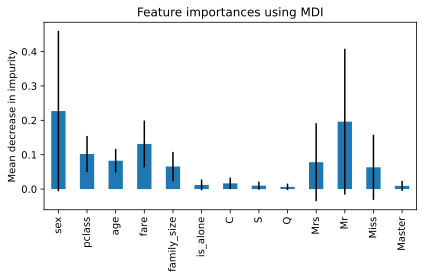

In [32]:
# Random Forest kan ikke fortelle oss direkte hvordan den kom fram til sin beslutninger, 
# Men den kan sjekke de forskjellige features, hvilke som er viktigst:
importances = modell.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in modell.estimators_], axis=0)

forest_importances = pd.Series(importances, index=df_x.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("random_forest.png")

VI ser at "sex" og "Mr" bidrar mest til besluningene. Begge disse uttrykker jo det samme, at flertallet av herrene døde, og flertallet av damene overlevde. 
I grafen over testes hver kolonne separat, så den sier ikke noe om hvilke kolonner som er overflødige. 
pclass og fare bidrar også, og disse to uttrykker også mye av det samme.
Alder og familiestørrlese ombord bidrar også. Grafen over sier inge ting om en økning i alder gir økt eller redusert sannsynlighet for å overleve. Men den negative korrelasjonskoeffisienten vi tok ut tidligere, indikerer at en høyere alder ga lavere sannsynlighetfor å overleve.

Hvis vi hadde kommet fram til at SUpport Vector Machine eller Nevralt nettverk hadde vært bedre til denne oppgaven, kunne vi ikke trukket ut grafen over. Den får vi fram fordi vi bruker Random Forest, som er sammensatt av mange Decision Trees, Grafen over viser gjennomsnittet av hvor viktig hver kolonne var for hvertav Decision Tree-ene. Svarte streka viser standardavviket, som er bra høyt. (Ikke bra som i at det er gunstig, men at det er mye)  

Hvis det er viktig å få ned antallet kolonner i datasettet, kunne vi nå begynt å ta bort en og en kolonne, og se hvor mye resultatet reduseres, og for hver kolonne vurdere om tapet av informasjon er akseptabelt.

## En siste opptelling
Vi skal nå telle opp hvor god klassifisering vi har kommet fram til. Vi ser på på hvert kjønn og klasse for seg, litt [slik vi gjorde tidligere](#hl1)

Passasjeklasse: 1.0 Kvinne: 1 Antall: 35 Overlevende 32 Accuracy: 0.9143 korrekte 32
Passasjeklasse: 1.0 Kvinne: 0 Antall: 33 Overlevende 12 Accuracy: 0.6364 korrekte 21
Passasjeklasse: 2.0 Kvinne: 1 Antall: 21 Overlevende 17 Accuracy: 0.8095 korrekte 17
Passasjeklasse: 2.0 Kvinne: 0 Antall: 28 Overlevende 8 Accuracy: 0.7143 korrekte 20
Passasjeklasse: 3.0 Kvinne: 1 Antall: 52 Overlevende 21 Accuracy: 0.4038 korrekte 21
Passasjeklasse: 3.0 Kvinne: 0 Antall: 93 Overlevende 10 Accuracy: 0.8925 korrekte 83
SamletAntall: 262 Overlevende 100 Accuracy: 0.7405 korrekte 234


In [41]:
# Random Forest:
modell = RandomForestClassifier(criterion = 'gini', max_depth=6, max_features='log2', n_estimators = 150)
steps = [('scaler', StandardScaler()), ('model', modell) ]
pipeline = Pipeline(steps)
pipeline.fit( df_x, y_train) 
test_comb["rf_estimated"] = pipeline.predict(df_x_test).astype(int)
for pc, pcg in test_comb.groupby("pclass"):
    for sx, sxg in pcg.groupby("sex"):
        acc = accuracy_score( sxg.survived, sxg.rf_estimated)
        print( "Passasjeklasse:",pc, "Kvinne:", sx, "Antall:", len(sxg),"Overlevende",sxg.survived.sum(), "Accuracy:", round(acc , 4), "korrekte", round(acc*len(sxg)))
print( "Samlet" "Antall:", len(test_comb),"Overlevende",test_comb.survived.sum(), "Accuracy:", round(accuracy_score( test_comb.survived, test_comb.sex_estimated) ,3
))

# VI ser at denne classifieren klarer å løfte prediksjonene for de lavere klassene, Særlig menn på andre klasse, og kvinner på tredje klasse.

Passasjeklasse: 1.0 Kvinne: 1 Antall: 35 Overlevende 32 Accuracy: 0.9143 korrekte 32
Passasjeklasse: 1.0 Kvinne: 0 Antall: 33 Overlevende 12 Accuracy: 0.697 korrekte 23
Passasjeklasse: 2.0 Kvinne: 1 Antall: 21 Overlevende 17 Accuracy: 0.8095 korrekte 17
Passasjeklasse: 2.0 Kvinne: 0 Antall: 28 Overlevende 8 Accuracy: 0.8214 korrekte 23
Passasjeklasse: 3.0 Kvinne: 1 Antall: 52 Overlevende 21 Accuracy: 0.5962 korrekte 31
Passasjeklasse: 3.0 Kvinne: 0 Antall: 93 Overlevende 10 Accuracy: 0.8925 korrekte 83
SamletAntall: 262 Overlevende 100 Accuracy: 0.74


In [42]:
# La oss også sjekke med den enklere Decision tree:
modell = tree.DecisionTreeClassifier()
# steps = [('scaler', StandardScaler()), ('model', modell) ]
# pipeline = Pipeline(steps)
# pipeline.fit( df_x, y_train) 
modell.fit( df_x, y_train) 
test_comb["dt_estimated"] = modell.predict(df_x_test).astype(int)
for pc, pcg in test_comb.groupby("pclass"):
    for sx, sxg in pcg.groupby("sex"):
        print( "Passasjeklasse:",pc, "Kvinne:", sx, "Accuracy:", round(accuracy_score( sxg.survived, sxg.dt_estimated) , 4))

print( "Samlet" "Antall:", len(test_comb),"Overlevende",test_comb.survived.sum(), "Accuracy:", round(accuracy_score( test_comb.survived, test_comb.dt_estimated) ,3
))
# Denne klarer å ta med informasjon som gjør at menn på andre klasse og kvinner på tredje klasse blir bedre predikert. Men ingen totalforbedring

Passasjeklasse: 1.0 Kvinne: 1 Accuracy: 0.9143
Passasjeklasse: 1.0 Kvinne: 0 Accuracy: 0.6364
Passasjeklasse: 2.0 Kvinne: 1 Accuracy: 0.7619
Passasjeklasse: 2.0 Kvinne: 0 Accuracy: 0.7857
Passasjeklasse: 3.0 Kvinne: 1 Accuracy: 0.6538
Passasjeklasse: 3.0 Kvinne: 0 Accuracy: 0.7312
SamletAntall: 262 Overlevende 100 Accuracy: 0.737


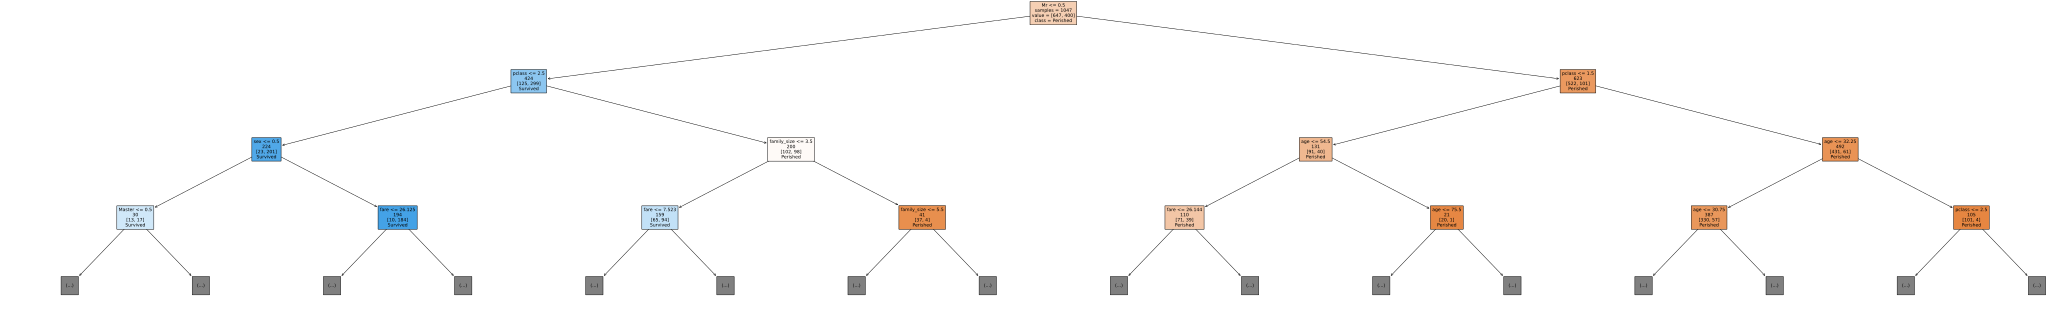

In [36]:
fig, axes = plt.subplots(figsize = (30,5), dpi=200)
tree.plot_tree(modell, max_depth = 3, feature_names = list(df_x_test.columns)
    , label='root', impurity=False,  filled=True, class_names = ["Perished", "Survived"])
plt.savefig("decisiontree.png")
plt.show()

In [37]:
from scipy.io import arff